# The Kaggle Rossman Competition

This was a kaggle competition to forecast sales at a pharmacy chain/dept store in Europe. It was run back in 2015.

Rossmann operates over 3,000 drug stores in 7 European countries. As a data analyst for this store chain, you are tasked with forecasting their daily sales for every store for up to six weeks in advance.

You will need to look at various factors influencing the forecast predictions - the primary ones being promotions, competition, school and state holidays, seasonality, and locality.


While working through this homework, you will:

1. see how to "grid-search" when the data is too large to use cross-validation. We will also learn how to use sklearn Pipelines to simplify the work-flow of different tranformation steps like Standardizing, One-hot encoding and Imputing missing values
2. understand some aspects of feature engineering that come in with continuous and categorical variables, and see some of the new features in sklearn 0.20
3. capture results from validation
4. learn what "categorical "embeddings" are and how they can be used to improve the performance of a multi-layer percepton



## QUESTION 1 : Preprocessing

In [64]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [65]:
from pathlib import Path

### 1.1 Load , check and clean the data

In [66]:
data = Path('./data')

We load the data from the 'data' folder and engage in some cleaning. A lot of cleaning of this dataset has already been done for us. Some features have been created. In particular we moved from dates to week-of-year, day-of week, etc. For example the 49th and 50th weeks of the year may have higher sales!

In [67]:
train_df = pd.read_csv(data/"train_clean.csv.gz", compression='gzip').drop(['index', 'PromoInterval'], axis=1)
test_df = pd.read_csv(data/"test_clean.csv.gz", compression='gzip').drop(['index', 'PromoInterval'], axis=1)

In [68]:
train_df['Events'] = train_df['Events'].fillna('None')
test_df['Events'] = test_df['Events'].fillna('None')

In [69]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [70]:
train_df.shape

(844338, 91)

Plot a histogram of Sales. What do you see?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268A5BB50F0>]],
      dtype=object)

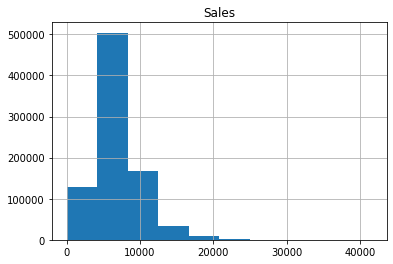

In [71]:
# your code here
train_df.hist('Sales')

We log-transform the dependent variable because it is long-tailed, i.e., the distribution has many occurrences far from the 'central' part of the distribution

In [72]:
train_resp = np.log(train_df['Sales'].copy())
train_df = train_df.drop('Sales', axis=1)
# We drop the 'Customers' from train_df and 'Id' from test_df as they're not present in the other dataframe
train_df = train_df.drop('Customers', axis=1)
test_df = test_df.drop('Id', axis=1)

Lets get some idea about our dataset - what are the different variables used? How do their values look like?

In [73]:
train_df.shape

(844338, 89)

In [74]:
train_df.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1,5,2015-07-31,1,1,False,1,2015,7,31,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,2,5,2015-07-31,1,1,False,1,2015,7,31,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,1,1,False,1,2015,7,31,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,4,5,2015-07-31,1,1,False,1,2015,7,31,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,1,1,False,1,2015,7,31,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [75]:
train_df.shape, test_df.shape

((844338, 89), (41088, 89))

The training and test datasets are already given to us sorted by the decreasing order of the 'date' column (the latest date being first)

In [76]:
train_df.Date # latest date first

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
5         2015-07-31
6         2015-07-31
7         2015-07-31
8         2015-07-31
9         2015-07-31
10        2015-07-31
11        2015-07-31
12        2015-07-31
13        2015-07-31
14        2015-07-31
15        2015-07-31
16        2015-07-31
17        2015-07-31
18        2015-07-31
19        2015-07-31
20        2015-07-31
21        2015-07-31
22        2015-07-31
23        2015-07-31
24        2015-07-31
25        2015-07-31
26        2015-07-31
27        2015-07-31
28        2015-07-31
29        2015-07-31
             ...    
844308    2013-01-02
844309    2013-01-02
844310    2013-01-02
844311    2013-01-02
844312    2013-01-02
844313    2013-01-02
844314    2013-01-02
844315    2013-01-02
844316    2013-01-02
844317    2013-01-02
844318    2013-01-02
844319    2013-01-02
844320    2013-01-02
844321    2013-01-01
844322    2013-01-01
844323    2013-01-01
844324    201

In [77]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'State', 'file', 'week', 'trend',
       'file_DE', 'week_DE', 'trend_DE', 'Date_DE', 'State_DE', 'Month_DE',
       'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE',
       'Is_month_start_DE', 'Is_quarter_end_DE', 'Is_quarter_start_DE',
       'Is_year_end_DE', 'Is_year_start_DE', 'Elapsed_DE', 'Max_TemperatureC',
       'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
       'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_Pressureh

In [78]:
train_resp.values

array([8.56845649, 8.71012493, 9.02569612, ..., 8.52416881, 8.40983067,
       8.69299353])

### 1.2 Types of variables and cardinality

We make a note of which variables are categorical and which are not. This is a choice. If cardinality(unique elements in a variable) is not too high, binning or categorizing can be beneficial. Often this will be true for integer valued variables.
>**Binning** is a way to group a number of more or less continuous values into a smaller number of "bins" or "categories"

In [79]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

We look for missing data and store the column names where this happend in the continuous data

In [80]:
nacols=[]
for v in cont_vars:
    if np.sum(train_df[v].isnull()) > 0:
        nacols.append(v)
        print(v, np.sum(train_df[v].isnull()))

CompetitionDistance 2186
CloudCover 68056


And look at some cardinalities (unique values) of the continuous data: if we have none below 10, we won't engage in binning. 
Print all continuous variables below and also print the unique elements for those variables for which the cardinality is less than 10 

In [81]:
# your code here
for i in cont_vars:
    if(len(train_df[i].unique())<10):
        print(i,train_df[i].unique())

<h2>My Answer: Therfore we have no continous variables for which the cardinality is less than 10

We do a similar looksie on the categorical variables. Some of these have many levels. Print all categorical variables below and also print the unique elements for those variables for which the cardinality is less than 50.  

In [82]:
# your code here
for i in cat_vars:
    print(i," : ",train_df[i].unique())

Store  :  [   1    2    3 ... 1115  876  292]
DayOfWeek  :  [5 4 3 2 1 7 6]
Year  :  [2015 2014 2013]
Month  :  [ 7  6  5  4  3  2  1 12 11 10  9  8]
Day  :  [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
StateHoliday  :  [False  True]
CompetitionMonthsOpen  :  [24  3 19  9  0 16 17  7 15 22 11 13  2 23 12  4 10  1 14 20  8 18  6 21
  5]
Promo2Weeks  :  [ 0 25 17  8 13 24 16  7 12 23 15  6 11 22 14  5 10 21  4  9 20  3 19  2
 18  1]
StoreType  :  ['c' 'a' 'd' 'b']
Assortment  :  ['a' 'c' 'b']
CompetitionOpenSinceYear  :  [2008 2007 2006 2009 2015 2013 2014 2000 2011 1900 2010 2005 1999 2003
 2012 2004 2002 1961 1995 2001 1990 1994 1998]
Promo2SinceYear  :  [1900 2010 2011 2012 2009 2014 2015 2013]
State  :  ['HE' 'TH' 'NW' 'BE' 'SN' 'SH' 'HB,NI' 'BY' 'BW' 'RP' 'ST' 'HH']
Week  :  [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36
 35 34 33 32]


### 1.3 Creating a validation set

The construction of a validation or "development" set is not always a `test_train_split` deal. Here we create a validation set of "latest" data, corresponding in date and size to what we have in the test set. Hopefully this will make sure we have similar distributions of features and outcomes on both.

#### Look at the train & test data and answer why we shouldn't have a random test-train split in this case

<h2>MY ANSWER: The Importance of latest data will be more than the old data as it will show the current trend of customers whereas the old data depicts the trend of that time and is not that reliable as the new one.

In [83]:
train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])]

40282    2015-06-19
40283    2015-06-19
40284    2015-06-19
40285    2015-06-19
40286    2015-06-19
40287    2015-06-19
40288    2015-06-19
40289    2015-06-19
40290    2015-06-19
40291    2015-06-19
40292    2015-06-19
40293    2015-06-19
40294    2015-06-19
40295    2015-06-19
40296    2015-06-19
40297    2015-06-19
40298    2015-06-19
40299    2015-06-19
40300    2015-06-19
40301    2015-06-19
40302    2015-06-19
40303    2015-06-19
40304    2015-06-19
40305    2015-06-19
40306    2015-06-19
40307    2015-06-19
40308    2015-06-19
40309    2015-06-19
40310    2015-06-19
40311    2015-06-19
            ...    
41366    2015-06-19
41367    2015-06-19
41368    2015-06-19
41369    2015-06-19
41370    2015-06-19
41371    2015-06-19
41372    2015-06-19
41373    2015-06-19
41374    2015-06-19
41375    2015-06-19
41376    2015-06-19
41377    2015-06-19
41378    2015-06-19
41379    2015-06-19
41380    2015-06-19
41381    2015-06-19
41382    2015-06-19
41383    2015-06-19
41384    2015-06-19


In [84]:
train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

41395

In [85]:
train_df['Date'][len(test_df)]

'2015-06-19'

In [86]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [87]:
valid_idx = range(cut)
train_idx = list(np.setdiff1d(range(train_df.shape[0]), valid_idx))

In [88]:
trdf = train_df.iloc[train_idx]
vadf = train_df.iloc[valid_idx]

In [89]:
trdf.shape, vadf.shape

((802943, 89), (41395, 89))

### 1.4 Transformation Pipelines

This is the definition of `pipeline` class according to scikit-learn is:
>Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit.

In most ML projects, there are quite often a number of transformational steps such as encoding categorical variables, feature scaling and normalisation that need to be performed. However, in a typical machine learning workflow you will need to apply all these transformations at least twice. Scikit-learn pipelines are a tool to simplify this process.

The pipeline class allows sticking multiple processes into a single scikit-learn estimator. It has fit, predict and score method just like any other estimator (ex. LinearRegression).

#### Why Pipelines?

1. Pipelines enforce implementation and desired order of steps in your project, which in turn helps in reproducibility and creating a convenient work-flow.
2. They also prevent data leakage in your validation set during cross-validation by ensuring that data preparation like standardization is constrained to each fold of your cross validation procedure.

Ok, now we'll use the new `ColumnTransformer` with imputation, missing-data indicators, the new `OrdinalEncoder`, and the usual `StandardScaler`. The [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) writes this about `ColumnTransformer`:
>Applies transformers to columns of an array or pandas DataFrame.
This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

In [90]:
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.pipeline import make_pipeline, make_union, Pipeline

In [91]:
impu = SimpleImputer(strategy="median") # replaces the missing values of a column by the median

In [92]:
mi = MissingIndicator() # create, fit, and transform a missingness indicator
mi.fit(trdf[nacols])
Xtrmi = mi.transform(trdf[nacols])
Xvami = mi.transform(vadf[nacols])

In [93]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
ss = StandardScaler()
oe = OrdinalEncoder()

In [94]:
trdf_cat = trdf[cat_vars]
trdf_cont = trdf[cont_vars]

We construct two pipelines, one for categoricals and one for continuous variables

The first step in building the pipeline is to define each transformer type. The convention here is generally to create transformers for the different variable types. All the continuous variables need to be median imputed (wherever required) and scaled, so we create a transformer which includes a SimpleImputer to fill in any missing values and applies a StandardScaler


In [95]:
cont_pipe = Pipeline([("imp",impu), ("scale", ss)])

#### Create a pipeline `cat_pipe` for categorical variables that should contain a transformer that can one-hot encode each variable

In [96]:
# your code here
from sklearn.preprocessing import OneHotEncoder
ohe= OneHotEncoder(handle_unknown='ignore')
cat_pipe=Pipeline([("oe",oe)])

We now combine them here in a transformer list.

In [97]:
transformers = [('cat', cat_pipe, cat_vars),
                    ('cont', cont_pipe, cont_vars)]

Now we use a `ColumnTransformer` to combine these and fit it on train data

In [98]:
from sklearn.compose import ColumnTransformer
ct= ColumnTransformer(transformers=transformers, remainder='drop')

In [99]:
ct.fit(trdf)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 Pipeline(memory=None,
                                          steps=[('oe',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>))],
                                          verbose=False),
                                 ['Store', 'DayOfWeek', 'Year', 'Month', 'Day',
                                  'StateHoliday', 'CompetitionMonthsOpen',
                                  'Promo2Weeks', 'StoreType', 'Assortment',
                                  'C...
                                                                verbose=0)),
                                                 ('scale',
                                                  StandardScaler(copy=True,
          

In [100]:
Xtr = ct.transform(trdf)
Xval = ct.transform(vadf)

In [101]:
Xtr.shape, Xtrmi.shape,Xval.shape,Xvami.shape

((802943, 37), (802943, 2), (41395, 37), (41395, 2))

In [102]:
print(Xtr)

[[ 1.11400000e+03  4.00000000e+00  2.00000000e+00 ...  5.96857197e-01
  -4.04391639e-01  8.95196255e-01]
 [ 0.00000000e+00  3.00000000e+00  2.00000000e+00 ...  5.96857197e-01
  -4.38484396e-01  8.95196255e-01]
 [ 1.00000000e+00  3.00000000e+00  2.00000000e+00 ...  5.96857197e-01
  -9.75568306e-02  8.95196255e-01]
 ...
 [ 7.68000000e+02  1.00000000e+00  0.00000000e+00 ... -3.75933276e-01
  -9.15782986e-01  8.95196255e-01]
 [ 9.47000000e+02  1.00000000e+00  0.00000000e+00 ... -3.75933276e-01
  -9.15782986e-01  8.95196255e-01]
 [ 1.09600000e+03  1.00000000e+00  0.00000000e+00 ... -3.75933276e-01
  -9.15782986e-01  8.95196255e-01]]


We concatenate the old indicators back in. The transformer lists all the categoricals first, since thats the first item in `transformers`, so we pre-pend.

In [103]:
Xtrain = np.concatenate([Xtrmi, Xtr], axis=1)
Xtrain.shape

(802943, 39)

In [104]:
Xvalid = np.concatenate([Xvami, Xval], axis=1)
Xvalid.shape

(41395, 39)

sklearn-pipelines lose our nice pandas names. so we bring them back.

In [105]:
cols = trdf.columns
actcols = []
actcolcount = 0
nacols_cat = []
for k in nacols:
    actcols.append((k+'_missing', 'cont'))
    nacols_cat.append(k+'_missing')
    actcolcount+=1
for k in cat_vars+cont_vars:
    if k in cat_vars:
        actcols.append((k, "cat"))
        actcolcount+=1
    if k in cont_vars:
        actcols.append((k, "cont"))
        actcolcount+=1
        
list(enumerate(actcols)), actcolcount

([(0, ('CompetitionDistance_missing', 'cont')),
  (1, ('CloudCover_missing', 'cont')),
  (2, ('Store', 'cat')),
  (3, ('DayOfWeek', 'cat')),
  (4, ('Year', 'cat')),
  (5, ('Month', 'cat')),
  (6, ('Day', 'cat')),
  (7, ('StateHoliday', 'cat')),
  (8, ('CompetitionMonthsOpen', 'cat')),
  (9, ('Promo2Weeks', 'cat')),
  (10, ('StoreType', 'cat')),
  (11, ('Assortment', 'cat')),
  (12, ('CompetitionOpenSinceYear', 'cat')),
  (13, ('Promo2SinceYear', 'cat')),
  (14, ('State', 'cat')),
  (15, ('Week', 'cat')),
  (16, ('Events', 'cat')),
  (17, ('Promo_fw', 'cat')),
  (18, ('Promo_bw', 'cat')),
  (19, ('StateHoliday_fw', 'cat')),
  (20, ('StateHoliday_bw', 'cat')),
  (21, ('SchoolHoliday_fw', 'cat')),
  (22, ('SchoolHoliday_bw', 'cat')),
  (23, ('Promo', 'cat')),
  (24, ('SchoolHoliday', 'cat')),
  (25, ('CompetitionDistance', 'cont')),
  (26, ('Max_TemperatureC', 'cont')),
  (27, ('Mean_TemperatureC', 'cont')),
  (28, ('Min_TemperatureC', 'cont')),
  (29, ('Max_Humidity', 'cont')),
  (30, ('

## Time to learn
We will follow two approches here to forecast sales and see how they perform relative to each other:
1. Gradient Boosting Regression Trees
2. Multi-layer Perceptron Model using Entity Embeddings


## QUESTION 2. Forecast using Gradient Boosting Regression Trees(GBRT)
We need to first split the y (the log of the y, really) into **ytrain** and **yvalid**

In [106]:
# your code here
ytrain=train_resp.iloc[train_idx]
yvalid=train_resp.iloc[valid_idx]

In [107]:
ytrain.shape, yvalid.shape

((802943,), (41395,))

and import what we need to for Gradient Boosting

In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
from sklearn.ensemble import GradientBoostingRegressor

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!) ([link](https://www.youtube.com/watch?v=-5l3g91NZfQ) here)

>Hyperparameter tuning - I usually follow this recipe to tune the hyperparameters:

> 
- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

>This last point is a trade-off between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate max_depth. And min_samples_per_leaf is not independent either, so if you do use cross-val, you might just use one of those.

### 2.1 Use Grid-search without cross-validation
We use `ParameterGrid` here to construct the entire grid for us! We put the output in a list of dictionaries and then save it in a dataframe. We might want to persist such dataframes to disk.

In [110]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [1,2, 3],
              'max_features': [0.2, 0.6]
              }

In [111]:
from sklearn.model_selection import ParameterGrid


Use the Gradient Boosting Regressor method **(n_estimators = 200)** to fit on your training data. Calculate the mean squared error for both the validation **('mse')** and the training set **('msetr')** for each combination of parameters in the `param_grid` and store the results along with the parameters in a list **'ds'**. [sklearn documentation link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [112]:
Xtr.shape

(802943, 37)

In [113]:
train_resp.shape

(844338,)

In [53]:
ds=[]
for p in ParameterGrid(param_grid):
    print(p)
    gbrt = GradientBoostingRegressor(loss='ls',n_estimators=200,learning_rate=p['learning_rate'],max_depth=p['max_depth'], random_state=0)
    gbrt.fit(Xtrain,ytrain)
    ytr_pred=gbrt.predict(Xtrain)
    yval_pred=gbrt.predict(Xvalid)
    result={}
    result['msetr']=mean_squared_error(ytrain,ytr_pred)
    result['mse']=mean_squared_error(yvalid,yval_pred)
    result['learning_rate']=p['learning_rate']
    result['max_depth']=p['max_depth']
    result['max_features']=p['max_features']
    ds.append(result)

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.2}
{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.6}
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.2}
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.6}
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.2}
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.6}
{'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.2}
{'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.6}
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 0.2}
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 0.6}
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.2}
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.6}


In [54]:
dsdf = pd.DataFrame.from_records(ds)
dsdf.sort_values('mse')

,learning_rate,max_depth,max_features,mse,msetr
4,0.10,3,0.2,0.088628,0.088139
5,0.10,3,0.6,0.088628,0.088139
2,0.10,2,0.2,0.104511,0.108578
3,0.10,2,0.6,0.104511,0.108578
0,0.10,1,0.2,0.119556,0.128064
1,0.10,1,0.6,0.119556,0.128064
10,0.01,3,0.2,0.123964,0.133281
11,0.01,3,0.6,0.123964,0.133281
8,0.01,2,0.2,0.130754,0.140747
9,0.01,2,0.6,0.130754,0.140747


### 2.2 Predict on the test data-set

We will now predict the sales on the test data-set

Use the best **GBRT** estimator and fit again on the training set

In [120]:
# your code here
gbrt1= GradientBoostingRegressor(loss='ls',n_estimators=200,learning_rate=0.1,max_depth=3,max_features=0.2, random_state=0)
gbrt1.fit(Xtr,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=0.2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

Use the Column transformer defined earlier to transform the test dataset and get it in the correct format. Follow the same process that we did for Xtrain and Xvalid.  

In [121]:
# your code here
ct1= ColumnTransformer(transformers=transformers, remainder='drop')
testct=ct1.fit_transform(test_df)

Predict the sales on the test data-set (**test_df**) and store the result in a new column **forecast_gb**

In [124]:
# your code here
forecast_gb=gbrt1.predict(testct)
forecast_gb

array([8.58946443, 8.75156786, 8.85297106, ..., 8.55878161, 8.68105497,
       8.64975051])

We shall now write a function to plot the forecasts vs the actual sales for the training and the test data combined. To do that, we first predict the sales on the **trdf** and **vadf**, concatenate the two dataframes together, add back the actual sales column **(train_resp)** and concatenate it again with **test_df**.

In [125]:
def forecast_plot(model, store, Xtrain, Xvalid):
    trdf['forecast'] = model.predict(Xtrain)
    vadf['forecast'] = model.predict(Xvalid)
    train_df = pd.concat([vadf,trdf])
    train_df['Actual'] = train_resp
    all_data = pd.concat([test_df, train_df])
    
    plt.figure(figsize=(20,8))
    plt.plot(pd.to_datetime(all_data[all_data['Store']==store]['Date']),all_data[all_data['Store']==store]['forecast'])
    plt.plot(pd.to_datetime(all_data[all_data['Store']==store]['Date']),all_data[all_data['Store']==store]['Actual'])
    plt.title('Forecast')
    plt.ylabel('Log Sales')
    plt.legend(['forecast', 'actual'], loc='best')
    plt.show()    

Plot the actual vs forecasted sales for Store 1

C:\Users\Ankit Kumar Pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ankit Kumar Pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ankit Kumar Pandey\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by defaul

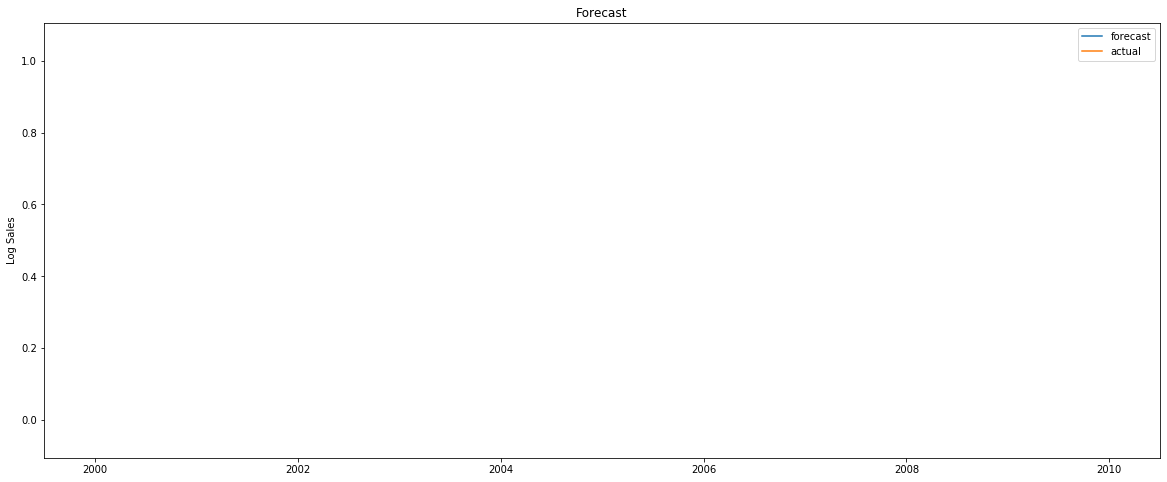

In [134]:
# your code here
forecast_plot(model=gbrt1,store='Store 1',Xtrain=Xtr,Xvalid=Xval)

## QUESTION 3. A Multi-Layer Perceptron Model

This is based on the 3rd prize winning entry, whose authors wrote a [paper](https://arxiv.org/pdf/1604.06737.pdf) afterwords.

What we are first going to do is to reduce the cardinality dimensionality of our categoricals by using **embeddings**. 

### What are embeddings?
An embedding is a mapping of discrete - categorical - variable to a vector of continuous variables. Neural Network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.
This technique is often used not only in recommender systems(via matrix factorization), but also in NLP models such as `word2vec`.

In our problem, consider the variable `store` as an example. This is a categorical predictor and we usually **one-hot encode** this - a single store would be of length 1115 bit-vector with one bit flipped on.

### Problems with One-hot encoding
1. The 1115 stores will have some commonalities, but the one-hot encoding doesn't represent this. The dot-product(cosine similarity) of any 2 one-hot encoded stores will be 0
2. The store variable has high cardinality (1115 unique categories) - in this case, the dimensionality of the transformed variable becomes unmanageable

Using embeddings for `store` will enable us to learn the store 'personalities', which can then be used later in other models for sales predictions, or even for other tasks.

### Training an embedding

- Normally you would do a linear or MLP regression with sales as the target, and both continuous and categorical features
- We need to replace the 1-hot encoded categorical features by "lower-width" embedding features.
- This is equivalent to considering a neural network with the output of an additional **Embedding Layer** concatenated in
- The Embedding Layer is simply a Linear Regression

![](./images/embmlp.png)

Here we divide the cardinality by 2 and add 1 to get the no. of embedding features (this is a heuristic). If the cardinality is high, we clamp the size of the latent space down at 50.

In [138]:
cards={}
for k in nacols_cat:
    cards[k] = (2,2)
for k in cat_vars :
    embed_sz_base = trdf[k].unique().size//2 + 1
    embed_sz = (embed_sz_base <=50)*embed_sz_base + 50*((embed_sz_base > 50))
    cards[k] = (trdf[k].unique().size, embed_sz)
cards

{'CompetitionDistance_missing': (2, 2),
 'CloudCover_missing': (2, 2),
 'Store': (1115, 50),
 'DayOfWeek': (7, 4),
 'Year': (3, 2),
 'Month': (12, 7),
 'Day': (31, 16),
 'StateHoliday': (2, 2),
 'CompetitionMonthsOpen': (25, 13),
 'Promo2Weeks': (26, 14),
 'StoreType': (4, 3),
 'Assortment': (3, 2),
 'CompetitionOpenSinceYear': (23, 12),
 'Promo2SinceYear': (8, 5),
 'State': (12, 7),
 'Week': (52, 27),
 'Events': (22, 12),
 'Promo_fw': (6, 4),
 'Promo_bw': (6, 4),
 'StateHoliday_fw': (8, 5),
 'StateHoliday_bw': (8, 5),
 'SchoolHoliday_fw': (8, 5),
 'SchoolHoliday_bw': (8, 5),
 'Promo': (2, 2),
 'SchoolHoliday': (2, 2)}

### 3.1 Building the model architecture using the Keras Functional API
We have to be careful (very book-keepy) in constructing a model in Keras. We use the Keras Functional API as opposed to the Sequential API. The architecture can be summarized in the below steps:
1. 25 input layers for categorical variables which feed into an Embedding Layer and then into a Reshape Layer
2. 14 input layers for continuous variables
3. Concatenating the 25 Reshape layers and the 14 input layers
4. Connecting the concatenated layer to a 1000 unit Dense Layer, which is connected to a 500 unit Dense Layer, which is then connected to the Output - a single unit Dense Layer

In [142]:
!pip install keras

In [144]:
!pip install tensorflow

  Stored in directory: C:\Users\Ankit Kumar Pandey\AppData\Local\pip\Cache\wheels\8e\28\49\fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Stored in directory: C:\Users\Ankit Kumar Pandey\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\Ankit Kumar Pandey\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\Ankit Kumar Pandey\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built absl-py termcolor gast opt-einsum


In [163]:
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding

def build_keras_model():
    input_cat = []
    output_embeddings = []
    for k in nacols_cat+cat_vars:
        print('{}_embedding'.format(k))
        input_1d = Input(shape=(1,))
        output_1d = Embedding(cards[k][0], cards[k][1], name='{}_embedding'.format(k))(input_1d)
        output = Reshape(target_shape=(cards[k][1],))(output_1d)
        input_cat.append(input_1d)
        output_embeddings.append(output)

    main_input = Input(shape=(len(cont_vars),), name='main_input')
    output_model = Concatenate()([main_input, *output_embeddings])
    output_model = Dense(1000, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(500, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(1)(output_model)
    kmodel = KerasModel(
        inputs=[*input_cat, main_input], 
        outputs=output_model
)
    kmodel.compile(loss='mean_squared_error', optimizer='adam')
    return kmodel

def fitmodel(kmodel, Xtr, ytr, Xval, yval, epochs, bs):
    h = kmodel.fit(Xtr, ytr, validation_data=(Xval, yval),
                       epochs=epochs, batch_size=bs)
    return h

The data input needs to match our construction:

In [164]:
list_cat_trains=[]
list_cat_valids=[]
catlen=len(nacols_cat+cat_vars)
for i in range(catlen):
    list_cat_trains.append(Xtrain[:,i])
    list_cat_valids.append(Xvalid[:,i])
cont_train=Xtrain[:,catlen:]
cont_valid=Xvalid[:,catlen:]

### 3.2 Run the model for 10 epochs and a batch-size of 256

In [165]:
# your code here
fitmodel(kmodel=gbrt1, Xtr=Xtrain,ytr=ytrain, Xval=Xval,yval=yvalid , epochs=10,bs=256)

TypeError: fit() got an unexpected keyword argument 'validation_data'

In [153]:
# Function to plot training vs validation loss
def plot_model_history(model_history):
    # summarize history for loss
    plt.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    plt.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.ylim([0,0.3])
    plt.legend(['train', 'val'], loc='best')
    plt.show()

Plot the training and validation loss across epochs

In [149]:
# your code here


How does the Categorical Embedding model perform as opposed to the GBRT model?

We predict the forecasts on the test data-set and then compare the actuals vs forecast for the entire data (train+test)

In [150]:
# your code here


Plot the actuals vs forecasts on the entire data-set

In [2]:
# your code here
